# Importing Data and Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import tensorflow as tf

import copy
import time

In [ ]:
# Loading the FashionMNIST data
train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)
X_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
y_test = test_set.targets.numpy()

100%|██████████| 26421880/26421880 [00:01<00:00, 16849911.63it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265067.24it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4922337.95it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13562988.06it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Pre-processing Data: Cleaning, Equalizing, and LabelEncoding

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
meanValue = np.mean(X_train)
stdValue = np.std(X_train)

X_train = (X_train - meanValue) / stdValue
X_test = (X_test - meanValue) / stdValue

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


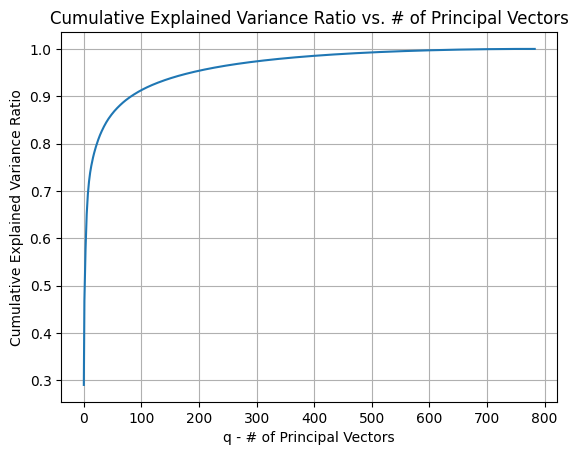

# of principal vectors for 90.0% of the variance: 84


In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

varianceRatio = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.90

principalVectors = np.argmax(varianceRatio >= threshold) + 1
X_train_reduced = X_train_pca[:, :principalVectors]
X_test_reduced = X_test_pca[:, :principalVectors]

plt.plot(varianceRatio)
plt.xlabel('q - # of Principal Vectors')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. # of Principal Vectors')
plt.grid(True)
plt.show()
print(f'# of principal vectors for {threshold*100}% of the variance: {principalVectors}')

# Model Construction and Training

In [ ]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, num_features, num_classes, l2=0.0):
        super(MultinomialLogisticRegression, self).__init__()
        self.layer1 = nn.Linear(num_features, num_classes)
        self.l2 = l2

    def forward(self, x):
        out = self.layer1(x)
        return out

In [ ]:
def resetWeights(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

def trainModel(model, epochs, lossFn, optimizer, X_train, X_test, y_train, y_test, decisionThreshold=0.5):
    trainAcc, testAcc = [], []
    trainErr, testErr = [], []
    trainLoss, testLoss = [], []

    resetWeights(model)
    for epoch in range(epochs):
        output = model(X_train)
        loss = lossFn(output.squeeze(), y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            trainLoss.append(loss.item())
            _, trainPredictions = torch.max(output, 1)
            trainError = torch.mean((trainPredictions != y_train_tensor).float())

            output = model(X_test)
            loss = lossFn(output.squeeze(), y_test)

            testLoss.append(loss.item())
            _, testPredictions = torch.max(output, 1)
            testError = torch.mean((testPredictions != y_test_tensor).float())

            trainErr.append(trainError.item())
            testErr.append(testError.item())
            trainAcc.append(1 - trainError.item())
            testAcc.append(1 - testError.item())

    return trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss


X_train_tensor = torch.tensor(X_train_reduced).float()
y_train_tensor = torch.tensor(y_train).long()
X_test_tensor = torch.tensor(X_test_reduced).float()
y_test_tensor = torch.tensor(y_test).long()

# Grid Search Analysis

In [ ]:
epochs_list = [50, 100, 500, 1000]
learning_rates = [1, 0.1, 0.01, 0.001]
momentums = [0, 0.5, 0.9, 0.99]
lambdas = [0, 0.001, 0.01, 0.1, 1]
trainedModels = []

num_features = X_train_tensor.shape[1]
num_classes = len(set(y_train))
lossFn = nn.CrossEntropyLoss()

for lambda_ in lambdas:
  model = MultinomialLogisticRegression(num_features, num_classes, l2=lambda_)
  for momentum in momentums:
    for lr in learning_rates:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=model.l2)
        for epochs in epochs_list:
          startTime = time.time()
          trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModel(
              model,
              epochs,
              lossFn,
              optimizer,
              X_train_tensor,
              X_test_tensor,
              y_train_tensor,
              y_test_tensor
          )
          trainingTime = time.time() - startTime
          trainedModels.append({ 'model': copy.deepcopy(model),
                                'hyperparameters': {'epochs': epochs, 'lr': lr, 'momentum': momentum, 'lambda': lambda_ },
                                'trainingStats': { 'testAcc': testAcc[-1], 'trainAcc': trainAcc[-1],
                                                    'testError': testErr[-1], 'trainError': trainErr[-1],
                                                    'testLoss': testLoss[-1], 'trainLoss': trainLoss[-1] },
                                'trainingTime': trainingTime
                                })
          print(f'Completed epochs, lr, momentum, lambda, test error: {epochs}, {lr}, {momentum}, {lambda_}, --- {testAcc[-1]}')

Completed epochs, lr, momentum, lambda, test error: 50, 1, 0, 0, --- 0.7539000064134598
Completed epochs, lr, momentum, lambda, test error: 100, 1, 0, 0, --- 0.7008999884128571
Completed epochs, lr, momentum, lambda, test error: 500, 1, 0, 0, --- 0.7819000035524368
Completed epochs, lr, momentum, lambda, test error: 1000, 1, 0, 0, --- 0.7942000031471252
Completed epochs, lr, momentum, lambda, test error: 50, 0.1, 0, 0, --- 0.7968000024557114
Completed epochs, lr, momentum, lambda, test error: 100, 0.1, 0, 0, --- 0.8129000067710876
Completed epochs, lr, momentum, lambda, test error: 500, 0.1, 0, 0, --- 0.8281999975442886
Completed epochs, lr, momentum, lambda, test error: 1000, 0.1, 0, 0, --- 0.8321000039577484
Completed epochs, lr, momentum, lambda, test error: 50, 0.01, 0, 0, --- 0.6829000115394592
Completed epochs, lr, momentum, lambda, test error: 100, 0.01, 0, 0, --- 0.7215999960899353
Completed epochs, lr, momentum, lambda, test error: 500, 0.01, 0, 0, --- 0.7983999997377396
Compl

# Finding the best model that maximizes accuracy



In [ ]:
globalOptimalModel = None
globalOptimalLoss = None
globalOptimalAcc = None

for model_ in trainedModels:
    optimalAcc = model_['trainingStats']['testAcc']
    optimalLoss = model_['trainingStats']['testLoss']

    if (globalOptimalLoss == None):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
    elif (optimalAcc > globalOptimalAcc):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_
    elif (optimalAcc == globalOptimalAcc and optimalLoss < globalOptimalLoss):
      globalOptimalLoss = optimalLoss
      globalOptimalAcc = optimalAcc
      globalOptimalModel = model_

print(globalOptimalModel)

{'model': MultinomialLogisticRegression(
  (layer1): Linear(in_features=84, out_features=10, bias=True)
), 'hyperparameters': {'epochs': 1000, 'lr': 0.1, 'momentum': 0.99, 'lambda': 0}, 'trainingStats': {'testAcc': 0.8378999978303909, 'trainAcc': 0.8528999984264374, 'testError': 0.16210000216960907, 'trainError': 0.14710000157356262, 'testLoss': 0.4695964753627777, 'trainLoss': 0.42241138219833374}, 'trainingTime': 59.36843967437744}


###33

In [ ]:
gLr = globalOptimalModel['hyperparameters']['lr']
gEpochs = globalOptimalModel['hyperparameters']['epochs']
gMomentum = globalOptimalModel['hyperparameters']['momentum']
gLambda = globalOptimalModel['hyperparameters']['lambda']

print(f'Global Optimal Model Hyperparameters: lr={gLr}, epochs={gEpochs}, momentum={gMomentum}, lamda={gLambda}')
print(f'Global Optimal Acc: {globalOptimalAcc}, Global Optimal Loss: {globalOptimalLoss}')

Global Optimal Model Hyperparameters: lr=0.1, epochs=1000, momentum=0.99, lamda=0
Global Optimal Acc: 0.8378999978303909, Global Optimal Loss: 0.4695964753627777


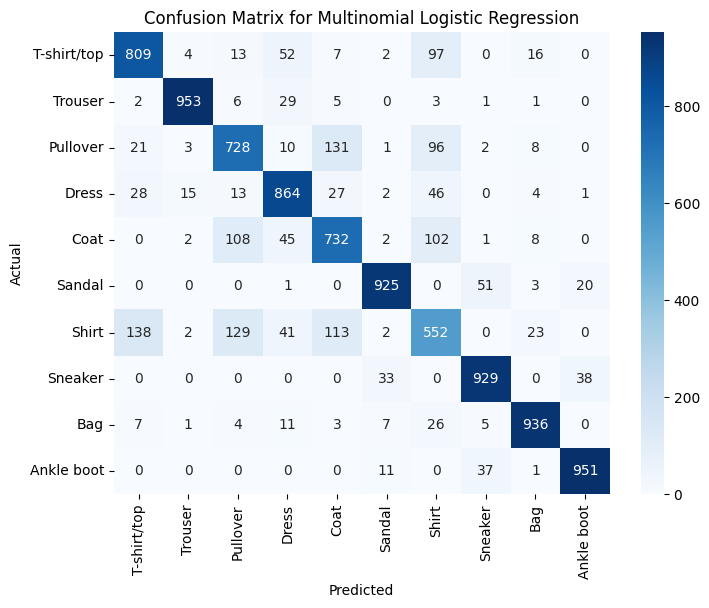

Precision: 0.8365093650277744, Recall: 0.8379, F1: 0.8370149063939903


In [ ]:
gModel = globalOptimalModel['model']
with torch.no_grad(): output = gModel(X_test_tensor)
_, testPredictions = torch.max(output, 1)
y_true = np.array(y_test_tensor)
y_pred = np.array(testPredictions)
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
labels = class_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Multinomial Logistic Regression')
plt.show()

print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')

## Reproducability Test & Visualizing Training Curves

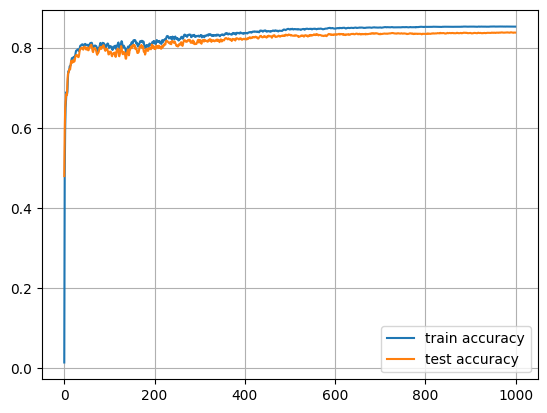

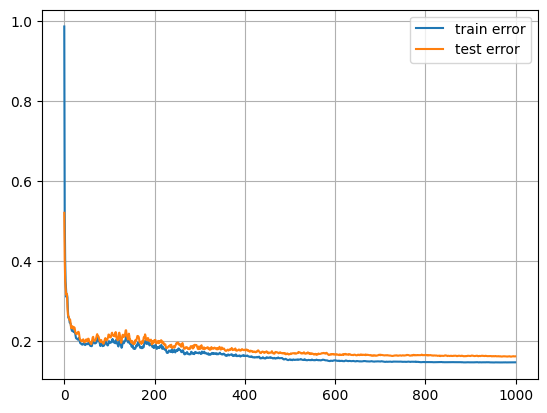

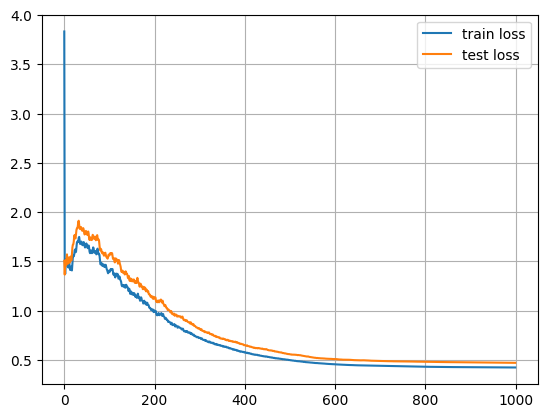

Train Accuracy: 0.8523333370685577, Train Error: 0.14766666293144226, Train Loss: 0.423554390668869
Test Accuracy: 0.8375000059604645, Test Error: 0.16249999403953552, Test Loss: 0.47068363428115845


In [ ]:
lr = globalOptimalModel['hyperparameters']['lr']
epochs = globalOptimalModel['hyperparameters']['epochs']
momentum = globalOptimalModel['hyperparameters']['momentum']
lambda_ = globalOptimalModel['hyperparameters']['lambda']


num_features = X_train_tensor.shape[1]
num_classes = len(set(y_train))
model = MultinomialLogisticRegression(num_features, num_classes, l2=lambda_)
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=model.l2)

trainAcc, testAcc, trainErr, testErr, trainLoss, testLoss = trainModel(
    model,
    epochs,
    lossFn,
    optimizer,
    X_train_tensor,
    X_test_tensor,
    y_train_tensor,
    y_test_tensor
)

model.eval()

plt.plot(trainAcc, label='train accuracy')
plt.plot(testAcc, label='test accuracy')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainErr, label='train error')
plt.plot(testErr, label='test error')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(trainLoss, label='train loss')
plt.plot(testLoss, label='test loss')
plt.grid(True)
plt.legend()

plt.show()

print(f'Global Optimal Model Hyperparameters: lr={lr}, epochs={epochs}, momentum={momentum}, lamda={lambda_}')
print(f'Train Accuracy: {trainAcc[-1]}, Train Error: {trainErr[-1]}, Train Loss: {trainLoss[-1]}')
print(f'Test Accuracy: {testAcc[-1]}, Test Error: {testErr[-1]}, Test Loss: {testLoss[-1]}')

# Time Complexity Analysis

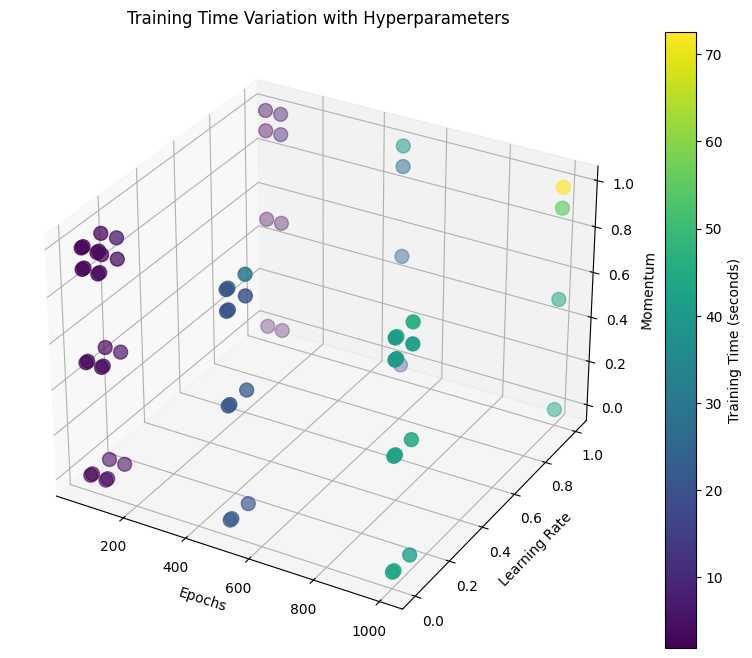

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

lambdaValue = 0.001
filteredModels = [modelInfo for modelInfo in trainedModels if modelInfo['hyperparameters']['lambda'] == lambdaValue]

epochsList = [modelInfo['hyperparameters']['epochs'] for modelInfo in filteredModels]
learningRates = [modelInfo['hyperparameters']['lr'] for modelInfo in filteredModels]
momentums = [modelInfo['hyperparameters']['momentum'] for modelInfo in filteredModels]
trainingTimes = [modelInfo['trainingTime'] for modelInfo in filteredModels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(epochsList, learningRates, momentums, c=trainingTimes, cmap='viridis', marker='o', s=100)
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Momentum')
ax.set_title('Training Time Variation with Hyperparameters')
cbar = plt.colorbar(sc)
cbar.set_label('Training Time (seconds)')

plt.show()
